# Imports


In [1]:
%load_ext autoreload
%autoreload 2


import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Neuron import Simulated_grid_cell
from spikeA.Animal_pose import Animal_pose
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from spikeA.Neuron import Neuron
import datetime

In [2]:
%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run neural_ds.py
%run sim_grid_func.py
%run functions.py

In [3]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Data prep


In [4]:
SIM_REANCHOR_ROTATION_ROOT = myProject.dataPath + "/results/simReanchorRotation/"
if not os.path.exists(SIM_REANCHOR_ROTATION_ROOT):
    os.makedirs(SIM_REANCHOR_ROTATION_ROOT)

In [5]:
SIM_REANCHOR_ROTATION_ROOT

'/ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/simReanchorRotation/'

In [6]:
onlyOF = SIM_REANCHOR_ROTATION_ROOT + "/jp451_lstm_firstRF.npy"
lastOF = SIM_REANCHOR_ROTATION_ROOT + "/jp451_lstm_lastRF.npy"

seed_value = 42
np.random.seed(seed_value)

# Functions

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def create_hex_grid(nx, ny, hex_radius, rotation_angle=0):
    """
    Create a hexagonal grid with optional rotation.
    """
    dx = 3 / 2 * hex_radius
    dy = np.sqrt(3) * hex_radius
    rotation_rad = np.radians(rotation_angle)
    rotation_matrix = np.array(
        [
            [np.cos(rotation_rad), -np.sin(rotation_rad)],
            [np.sin(rotation_rad), np.cos(rotation_rad)],
        ]
    )

    centers = []
    vertices = []
    for x in range(-nx, nx):
        for y in range(-ny, ny):
            cx = x * dx
            cy = y * dy + (x % 2) * dy / 2
            center = np.array([cx, cy])
            rotated_center = rotation_matrix @ center
            centers.append(rotated_center)
            hex_vertices = get_hex_vertices(cx, cy, hex_radius)
            rotated_vertices = [
                rotation_matrix @ np.array(vertex) for vertex in hex_vertices
            ]
            vertices.extend(rotated_vertices)

    return centers, vertices


def get_hex_vertices(cx, cy, hex_radius):
    """
    Calculate vertices of a hexagon given center and radius.
    """
    vertices = []
    for angle in range(0, 360, 60):
        x = cx + hex_radius * np.cos(np.radians(angle))
        y = cy + hex_radius * np.sin(np.radians(angle))
        vertices.append((x, y))
    return vertices


def shift_grid(centers, vertices, shift_x, shift_y):
    """
    Shift the entire grid by adding shift_x and shift_y to the coordinates of centers and vertices.
    """
    shifted_centers = [(x + shift_x, y + shift_y) for x, y in centers]
    shifted_vertices = [(x + shift_x, y + shift_y) for x, y in vertices]
    return shifted_centers, shifted_vertices


def draw_circles(
    ax, centers, vertices, circle_radius, clip_path, circle_color="#ffcb77"
):
    """
    Draw circles at hexagon centers and vertices with clipping.
    """
    for center in centers:
        center_circle = plt.Circle(
            center, circle_radius, color=circle_color, fill=True, alpha=0.6
        )
        center_circle.set_clip_path(clip_path)  # Apply clipping path
        ax.add_patch(center_circle)
        ax.add_patch(center_circle)
        ax.add_patch(center_circle)

    for vertex in vertices:
        vertex_circle = plt.Circle(
            vertex, circle_radius, color=circle_color, fill=True, alpha=0.6
        )
        vertex_circle.set_clip_path(clip_path)  # Apply clipping path
        ax.add_patch(vertex_circle)
        
def rotate_center_vertex_list(inputList,rotation):
    return [
        rotate_point_with_start(inputList[i][0],inputList[i][1],rotation,0,0)
        for i in range(len(inputList))
    ]
    
def plot_grid_pattern(
    ax, grid_offset_x, grid_offset_y, rotation=0, circle_color="#ffcb77",startingPose=None
):

    # Parameters for a larger grid
    nx = 5
    ny = 5
    grid_sp = 40
    hex_radius = grid_sp
    circle_radius = hex_radius / 3
    rotation_angle = 30   # Starting angle
    

    real_shift_x = grid_offset_x
    real_shift_y = grid_offset_y


    real_shift_x = real_shift_x % hex_radius
    real_shift_y = real_shift_y % hex_radius
    

    shift_x = grid_offset_x % hex_radius
    shift_y = grid_offset_y % hex_radius

    # Set limits to crop to a specific area
    ax.set_xlim(-42, 42)
    ax.set_ylim(-42, 42)

    centers, vertices = create_hex_grid(nx, ny, hex_radius, rotation_angle)
    shifted_centers, shifted_vertices = shift_grid(centers, vertices, shift_x, shift_y)
    
    shifted_centers = rotate_center_vertex_list(shifted_centers,rotation)
    shifted_vertices = rotate_center_vertex_list(shifted_vertices,rotation)


    clipping_circle = patches.Circle((0, 0), 41, transform=ax.transData)

    # Draw circles with clipping
    draw_circles(
        ax,
        shifted_centers,
        shifted_vertices,
        circle_radius,
        clipping_circle,
        circle_color=circle_color,
    )

    ax.axis("off")
    ax.set_aspect("equal")

def plot_from_grid_param_list(ax, grid_param_list, neuronNum=0):
    

    colorList = ["#FFCB77", "#FE6D73", "#17C3B2", "#227C9D", "#D68C45"]
    colorList = ['#FFCB77','#fe6d73','#17c3b2','#C0FDFF','#227c9d']

    for i, gp in enumerate(grid_param_list):
        shift_x = gp["offset"][neuronNum][0]
        shift_y = gp["offset"][neuronNum][1]
        
        rotation = gp["rotation"]

        plot_grid_pattern(
            ax, shift_x, shift_y, rotation=rotation, circle_color=colorList[i % 5]
        )

    ax.add_patch(
        patches.Circle((0, 0), 41, edgecolor="#284b63", facecolor="none", linewidth=3)
    )

def rotate_point_with_start(X, Y, angle, a, b):
    if np.isnan(angle):
        theta = 0  # Convert NaN angles to 0
    else:
        theta = angle

    # Translate point to make (a, b) the origin
    translated_X = X - a
    translated_Y = Y - b

    # Apply the rotation transformation around the new origin
    new_X = translated_X * np.cos(theta) - translated_Y * np.sin(theta)
    new_Y = translated_X * np.sin(theta) + translated_Y * np.cos(theta)

    # Translate point back
    final_X = new_X + a
    final_Y = new_Y + b

    return (final_X, final_Y)

In [8]:
# Save plots
import pickle
import numpy as np

def save_reanchor_rotation_obj(filename = SIM_REANCHOR_ROTATION_ROOT + "reanchor_rotation_obj.pkl"):
    """
    Save all the data needed for the reanchoring scenarios plot
    """
    reanchor_rotation_obj = {
        # Grid parameters
        'grid_param': grid_param,
        'reanchorGenerated': reanchorGenerated,
        'rotationGenerated': rotationGenerated,
        'm_reanchorGenerated': m_reanchorGenerated,
        'm_rotationGenerated': m_rotationGenerated,
        'inco_reanchorGenerated': inco_reanchorGenerated,
        'test_neuron_list3': test_neuron_list3,
        'jumpNeuron': jumpNeuron,
        'rotateNeuron': rotateNeuron,
        'm_jumpNeuron': m_jumpNeuron,
        'mr_jumpNeuron': mr_jumpNeuron,
        'inco_jumpNeuron': inco_jumpNeuron,
        'firingAssoci': firingAssoci,
        'mvtDirError_n': mvtDirError_n,
        'mvtDirError_an': mvtDirError_an,
        'mvtDirError_r': mvtDirError_r,
        'mvtDirError_m_an': mvtDirError_m_an,
        'mvtDirError_m_r': mvtDirError_m_r,
        'mvtDir_inco_an': mvtDir_inco_an
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(reanchor_rotation_obj, f)
    
    print(f"Data saved to {filename}")
    
def load_plot_data(filename):
    """
    Load all the data needed for the reanchoring scenarios plot
    """
    with open(filename, 'rb') as f:
        reanchor_rotation_obj = pickle.load(f)
    
    return reanchor_rotation_obj

def load_reanchor_rotation_obj(data_file):
    """
    Create the reanchoring scenarios plot using saved data
    """
    # Load the data
    data = load_plot_data(data_file)
    
    # Extract variables
    grid_param = data['grid_param']
    reanchorGenerated = data['reanchorGenerated']
    rotationGenerated = data['rotationGenerated']
    m_reanchorGenerated = data['m_reanchorGenerated']
    m_rotationGenerated = data['m_rotationGenerated']
    inco_reanchorGenerated = data['inco_reanchorGenerated']
    
   
    # Use full neuron objects
    test_neuron_list3 = data['test_neuron_list3']
    jumpNeuron = data['jumpNeuron']
    rotateNeuron = data['rotateNeuron']
    m_jumpNeuron = data['m_jumpNeuron']
    mr_jumpNeuron = data['mr_jumpNeuron']
    inco_jumpNeuron = data['inco_jumpNeuron']
    
    mvtDirError_n = data['mvtDirError_n']
    mvtDirError_an = data['mvtDirError_an']
    mvtDirError_r = data['mvtDirError_r']
    mvtDirError_m_an = data['mvtDirError_m_an']
    mvtDirError_m_r = data['mvtDirError_m_r']
    mvtDir_inco_an = data['mvtDir_inco_an']
    
    firingAssoci = data['firingAssoci']

    return (
        grid_param,
        reanchorGenerated,
        rotationGenerated,
        m_reanchorGenerated,
        m_rotationGenerated,
        inco_reanchorGenerated,
        test_neuron_list3,
        jumpNeuron,
        rotateNeuron,
        m_jumpNeuron,
        mr_jumpNeuron,
        inco_jumpNeuron,
        firingAssoci,
        mvtDirError_n,
        mvtDirError_an,
        mvtDirError_r,
        mvtDirError_m_an,
        mvtDirError_m_r,
        mvtDir_inco_an

    )



In [9]:
def plot_scatterplot_association(ax, inputDf,x, y, xlabel, ylabel, title=''):
    sns.scatterplot(data=inputDf,x=x, y= y,legend=False,color=['#ff9f1c'],**stripplot_kwargs)

    ax.set_xlim(-0.3,1)
    ax.set_ylim(-0.3,1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel(xlabel,fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    
    r,p = pearsonr(inputDf[x],inputDf[y])
    
    N = len(inputDf[x])
    ax.text(0.05,0.8,f"r = {r:.2f}",fontsize=GLOBALFONTSIZE,transform=ax.transAxes)
    ax.text(0.05,0.9,f"N = {N}",fontsize=GLOBALFONTSIZE,transform=ax.transAxes)
    

In [10]:
def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.nanmean(np.cos(mvtDirError))
    yMean = np.nanmean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)

def plot_mvl(ax,mvtDirError):
    sns.histplot(mvtDirError,bins=np.linspace(-np.pi,np.pi,20),ax=ax,stat='density',color='#2ec4b6')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Pred. directional error",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Density",fontsize=GLOBALFONTSIZE)
    
    ax.text(0.05,0.9,f"MVL: {np.round(vl_mvt_direction_error(mvtDirError),2)}", transform=ax.transAxes, fontsize=GLOBALFONTSIZE)
    
    ax.set_xticks([-np.pi,0,np.pi])
    ax.set_xticklabels(['$-\pi$','$0$','$\pi$'],fontsize=GLOBALFONTSIZE)
    
    ax.set_ylim(0,1)

In [11]:
def plotMap(
    ax,
    myMap,
    title="",
    titleY=0.95,
    titleFontSize=10,
    transpose=True,
    cmap="jet",
    vmin=0,
    alpha=1,
):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(
            myMap.T,
            origin="lower",
            cmap=cmap,
            interpolation=None,
            vmin=vmin,
            alpha=alpha,
        )
    else:
        ax.imshow(
            myMap, origin="lower", cmap=cmap, interpolation=None, vmin=vmin, alpha=alpha
        )
    ax.set_title(title, y=titleY, fontsize=titleFontSize)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Make figure

In [12]:
(
    grid_param,
    reanchorGenerated,
    rotationGenerated,
    m_reanchorGenerated,
    m_rotationGenerated,
    inco_reanchorGenerated,
    test_neuron_list3,
    jumpNeuron,
    rotateNeuron,
    m_jumpNeuron,
    mr_jumpNeuron,
    inco_jumpNeuron,
    firingAssoci,
    mvtDirError_n,
    mvtDirError_an,
    mvtDirError_r,
    mvtDirError_m_an,
    mvtDirError_m_r,
    mvtDir_inco_an,
) = load_reanchor_rotation_obj(data_file = SIM_REANCHOR_ROTATION_ROOT + "reanchor_rotation_obj.pkl")

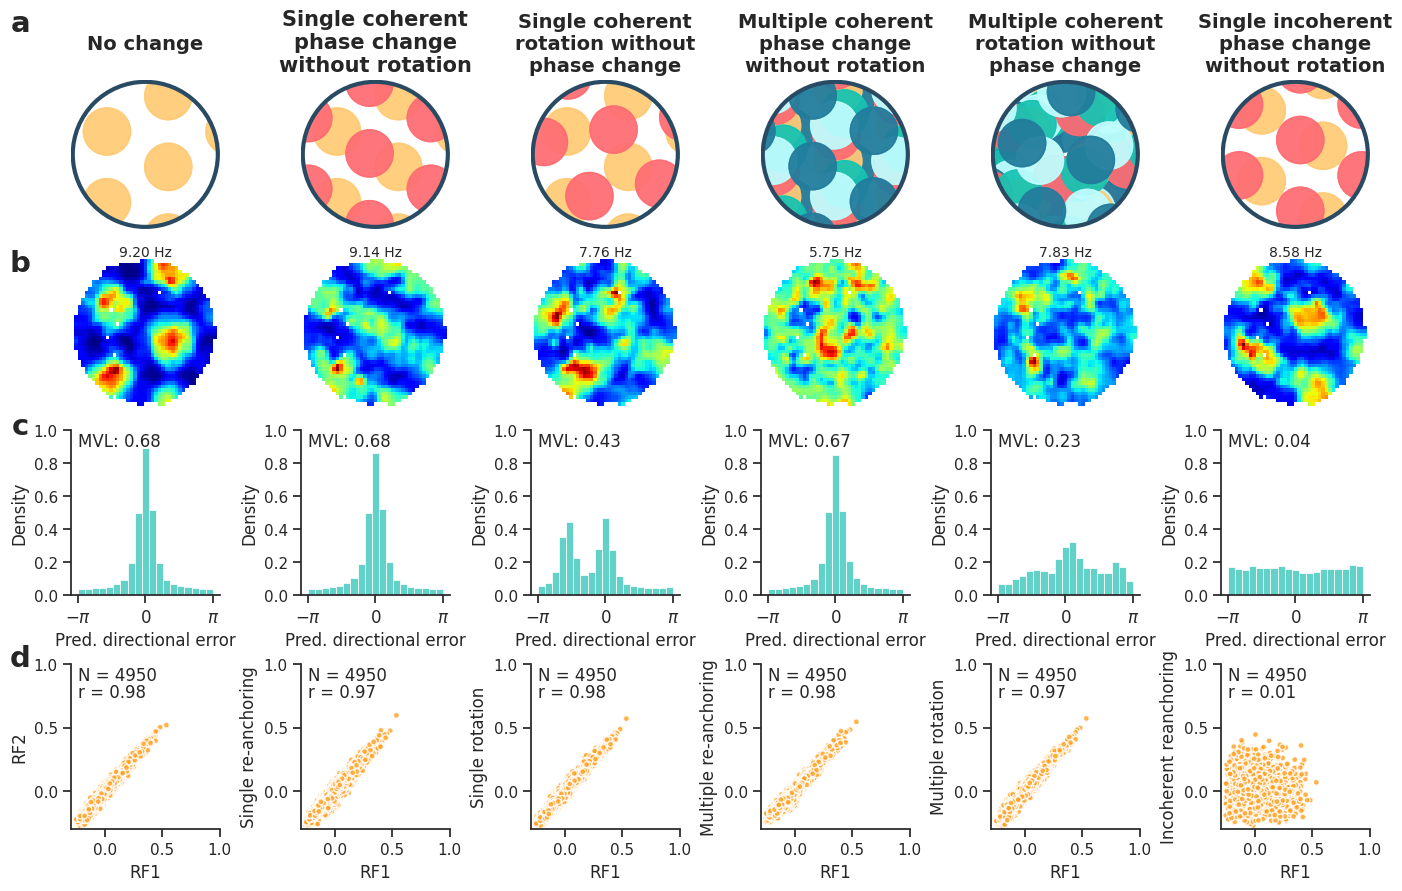

In [13]:
# Make a figure with grid pattern and the distortions it could have
from matplotlib.gridspec import GridSpecFromSubplotSpec


GLOBALFONTSIZE = 12

rowSize, colSize = 2.2, 2.3
ncols = 6
nrows = 4
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
sns.set(rc={"figure.dpi": 100, "savefig.dpi": 100})

# Data Used For Making the Plot
sns.set_theme(style="ticks")
def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label,style='normal',fontweight=fw,fontsize=GLOBALFONTSIZE+9,verticalalignment='center',horizontalalignment='center',transform = ax.transAxes)
    
size=GLOBALFONTSIZE+2

# NOTE - First ROW:
ax0 = fig.add_subplot(gs[0, 0])
gp = [{"offset": grid_param['offset'],
       'rotation':0}]
plot_from_grid_param_list(ax0,gp)
ax0.set_title("No change\n ", fontsize=GLOBALFONTSIZE+2,fontweight='bold')

ax0 = fig.add_subplot(gs[0, 1])
gp = reanchorGenerated[6]
plot_from_grid_param_list(ax0,gp)
ax0.set_title("Single coherent\nphase change\nwithout rotation", fontsize=GLOBALFONTSIZE+3,fontweight='bold')

ax0 = fig.add_subplot(gs[0, 2])
gp = rotationGenerated[6]
plot_from_grid_param_list(ax0,gp)
ax0.set_title("Single coherent\nrotation without\nphase change", fontsize=GLOBALFONTSIZE+2,fontweight='bold')

ax0 = fig.add_subplot(gs[0, 3])
gp = m_reanchorGenerated[6]
plot_from_grid_param_list(ax0,gp)
ax0.set_title("Multiple coherent\nphase change\nwithout rotation", fontsize=GLOBALFONTSIZE+2,fontweight='bold')

ax0 = fig.add_subplot(gs[0, 4])
gp = m_rotationGenerated[6]
plot_from_grid_param_list(ax0,gp)
ax0.set_title("Multiple coherent\nrotation without\nphase change", fontsize=GLOBALFONTSIZE+2,fontweight='bold')

ax0 = fig.add_subplot(gs[0, 5])
gp = inco_reanchorGenerated[6]
plot_from_grid_param_list(ax0,gp)
ax0.set_title("Single incoherent\nphase change\nwithout rotation", fontsize=GLOBALFONTSIZE+2,fontweight='bold')


# NOTE - Second row
ax0 = fig.add_subplot(gs[1, 0])
n1 = test_neuron_list3[0]
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)


ax0 = fig.add_subplot(gs[1, 1])
n1 = jumpNeuron
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)




ax0 = fig.add_subplot(gs[1, 2])
n1 = rotateNeuron
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)



ax0 = fig.add_subplot(gs[1, 3])
n1 = m_jumpNeuron
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)


ax0 = fig.add_subplot(gs[1, 4])
n1 = mr_jumpNeuron
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)



ax0 = fig.add_subplot(gs[1, 5])
n1 = inco_jumpNeuron
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)


# NOTE - Third row
ax0 = fig.add_subplot(gs[2, 0])
plot_mvl(ax0,mvtDirError_n)

ax0 = fig.add_subplot(gs[2, 1])
plot_mvl(ax0,mvtDirError_an)

ax0 = fig.add_subplot(gs[2, 2])
plot_mvl(ax0,mvtDirError_r)

ax0 = fig.add_subplot(gs[2, 3])
plot_mvl(ax0,mvtDirError_m_an)

ax0 = fig.add_subplot(gs[2, 4])
plot_mvl(ax0,mvtDirError_m_r)

ax0 = fig.add_subplot(gs[2, 5])
plot_mvl(ax0,mvtDir_inco_an)

# # NOTE - Fourth row
ax0 = fig.add_subplot(gs[3, 0])
plot_scatterplot_association(ax0,firingAssoci,'RF1','RF2','RF1','RF2','')

ax0 = fig.add_subplot(gs[3, 1])
plot_scatterplot_association(ax0,firingAssoci,'RF1','reanchor','RF1','Single re-anchoring','')

ax0 = fig.add_subplot(gs[3, 2])
plot_scatterplot_association(ax0,firingAssoci,'RF1','rotate','RF1','Single rotation','')

ax0 = fig.add_subplot(gs[3, 3])
plot_scatterplot_association(ax0,firingAssoci,'RF1','multipleReanchoring','RF1','Multiple re-anchoring','')

ax0 = fig.add_subplot(gs[3, 4])
plot_scatterplot_association(ax0,firingAssoci,'RF1','multipleRotation','RF1','Multiple rotation','')

ax0 = fig.add_subplot(gs[3, 5])
plot_scatterplot_association(ax0,firingAssoci,'RF1','incoherentReanchoring','RF1','Incoherent reanchoring','')



gsT = GridSpecFromSubplotSpec(1,1,subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gsT[:,:])


#Add figure legend
add_text(ax0,0,1,'a',fw='bold')
add_text(ax0,0,0.72,'b',fw='bold')
add_text(ax0,0,0.53,'c',fw='bold')
add_text(ax0,0,0.26,'d',fw='bold')

ax0.axis('off')

plt.savefig('../../Output/Sup_Figure7.pdf', bbox_inches='tight', dpi=300)